# Testing ML techniques to identify YSOs in Spitzer IRAC data

## Breanna Crompvoets 

## Import Libraries and set global variables

In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data
custom_labs = ['Class 1', 'Class 2', 'Others']


/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Classical ML Techniques

## Loading Data Set

In [2]:
# data load
X = np.load("../inp.npy")
Y = np.load("../tar.npy")
input_te = np.load("../inp_test.npy")
target_te = np.load("../tar_test.npy") 


(array([[0.000e+00, 7.000e+00, 4.900e+01, 1.510e+02, 4.170e+02, 1.019e+03,
         2.008e+03, 1.472e+03, 2.150e+02, 4.300e+01],
        [0.000e+00, 1.100e+01, 7.200e+01, 1.790e+02, 4.460e+02, 1.048e+03,
         2.066e+03, 1.421e+03, 1.370e+02, 1.000e+00],
        [2.000e+00, 2.600e+01, 7.900e+01, 2.140e+02, 4.700e+02, 1.068e+03,
         2.171e+03, 1.340e+03, 1.100e+01, 0.000e+00],
        [1.800e+01, 3.400e+01, 1.140e+02, 2.420e+02, 4.880e+02, 1.124e+03,
         2.299e+03, 1.061e+03, 1.000e+00, 0.000e+00]]),
 array([ 3.419 ,  4.8702,  6.3214,  7.7726,  9.2238, 10.675 , 12.1262,
        13.5774, 15.0286, 16.4798, 17.931 ]),
 <a list of 4 BarContainer objects>)

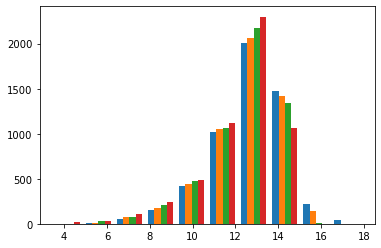

In [21]:
plt.hist(input_te)

(array([[0.000e+00, 5.000e+00, 3.160e+02, 1.344e+03, 3.262e+03, 6.268e+03,
         8.494e+03, 8.564e+03, 1.511e+03, 2.360e+02],
        [0.000e+00, 1.390e+02, 7.740e+02, 1.801e+03, 4.458e+03, 6.953e+03,
         8.431e+03, 6.865e+03, 5.640e+02, 1.500e+01],
        [5.000e+01, 3.630e+02, 1.294e+03, 2.615e+03, 5.188e+03, 6.718e+03,
         8.250e+03, 5.351e+03, 1.710e+02, 0.000e+00],
        [1.950e+02, 8.980e+02, 1.684e+03, 3.981e+03, 5.755e+03, 6.787e+03,
         6.326e+03, 4.295e+03, 7.900e+01, 0.000e+00]]),
 array([ 2.03662362,  3.61030621,  5.1839888 ,  6.75767139,  8.33135398,
         9.90503657, 11.47871916, 13.05240174, 14.62608433, 16.19976692,
        17.77344951]),
 <a list of 4 BarContainer objects>)

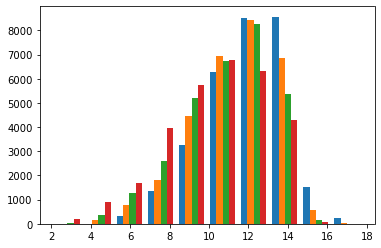

In [22]:
plt.hist(X)

In [23]:
def bootstrap_estimate(estimator, X, Y, inp_te, tar_te, n_splits=200):
                          
    scoresA = []
    scoresP = []
    scoresR = []
    
    for n in range(0,n_splits):
        inp_tr, inp_va, tar_tr, tar_va = train_test_split(X,Y) 
        scaler_S = StandardScaler().fit(inp_tr)
        inp_tr = scaler_S.transform(inp_tr)
        inp_va = scaler_S.transform(inp_va)
        inp_te = scaler_S.transform(inp_te)
        estimator.fit(inp_tr, tar_tr.ravel())  
        pred_te = estimator.predict(inp_te)
        scoresA.append(accuracy_score(tar_te,pred_te))
        scoresR.append(recall_score(tar_te,pred_te,average=None,zero_division=1))  
        scoresP.append(precision_score(tar_te,pred_te,average=None,zero_division=1)) 
        
    scoresR = list(map(list, zip(*scoresR)))
    scoresP = list(map(list, zip(*scoresP)))

    estimateA = np.mean(scoresA)*100.
    stderrA = np.std(scoresA)*100.
    
    estimateR = [np.mean(scoresR[0])*100.,np.mean(scoresR[1])*100.,np.mean(scoresR[2])*100.]
    stderrR = [np.std(scoresR[0])*100.,np.std(scoresR[1])*100.,np.std(scoresR[2])*100.]
    
    estimateP = [np.mean(scoresP[0])*100.,np.mean(scoresP[1])*100.,np.mean(scoresP[2])*100.]
    stderrP = [np.std(scoresP[0])*100.,np.std(scoresP[1])*100.,np.std(scoresP[2])*100.]
    
    return estimateR, stderrR, estimateP, stderrP, estimateA, stderrA

def bootstrap_to_file(file, estimator, X, Y, input_te, target_te, n_splits=200):
    estR, stderrR, estP, stderrP, estA, stderrA = bootstrap_estimate(estimator, X, Y, input_te, target_te, n_splits=n_splits)
    classes = ["Class I", "Class II", "Contaminants"]
    for i, cl in enumerate(classes):
        if i==1:
            file.write(cl+"& $"+"{:.1f}".format(estR[i])+"\pm"+"{:.1f}".format(stderrR[i])+"$ & $"+
                "{:.1f}".format(estP[i])+"\pm"+"{:.1f}".format(stderrP[i])+"$ & $"+"{:.1f}".format(estA)+"\pm"+"{:.1f}".format(stderrA)+"$ // \n")
        else:
            file.write(cl+"& $"+"{:.1f}".format(estR[i])+"\pm"+"{:.1f}".format(stderrR[i])+"$ & $"+
                "{:.1f}".format(estP[i])+"\pm"+"{:.1f}".format(stderrP[i])+"$&// \n")


In [24]:
f = open("PRAScores_ArtificialBalance_TestSet.txt","w")
f.write("Artificially balanced dataset provided by Hossen Teimoorinia \n")

62

## Logistic Regression

In [25]:
%%time

logreg = LogisticRegression('l1',max_iter=500,solver='saga',tol=0.0001)

CPU times: user 62 µs, sys: 30 µs, total: 92 µs
Wall time: 102 µs


In [26]:
classes = ["Class I", "Class II", "Contaminants"]
f.write("LR Recall & Precision & Accuracy\n")
bootstrap_to_file(f, logreg, X, Y, input_te, target_te, n_splits=200)


## SVM

In [27]:
svc = SVC(kernel='rbf',gamma='auto',C=0.9)

In [28]:
f.write("SVC Recall & Precision & Accuracy\n")
bootstrap_to_file(f, svc, X, Y, input_te, target_te, n_splits=200)

## SVM/LR Stacking Ensemble 

In [29]:
estimators = [('svc', SVC(kernel='rbf',gamma='auto',C=0.9,random_state=42))]
stacl = StackingClassifier(estimators=estimators,
                           final_estimator=LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga', tol =0.0001))

In [30]:
f.write("Stack Recall & Precision & Accuracy\n")
bootstrap_to_file(f, stacl, X, Y, input_te, target_te, n_splits=200)

## Random Forest


In [31]:
# Final hyperparameters
rfcl = RandomForestClassifier(class_weight='balanced',criterion='entropy',max_features='log2',n_estimators=100,oob_score=False)

In [32]:
f.write("RF Recall & Precision & Accuracy\n")
bootstrap_to_file(f, rfcl, X, Y, input_te, target_te, n_splits=200)

## Gradient Boosting

In [33]:
boostcl = GradientBoostingClassifier(criterion='friedman_mse',max_depth=7,max_features='log2',
                n_estimators=100,n_iter_no_change=5,subsample=1.0,warm_start=True)

In [34]:
f.write("GB Recall & Precision & Accuracy\n")
bootstrap_to_file(f, boostcl, X, Y, input_te, target_te, n_splits=200)

## XGBoost


In [35]:
xgbcl = xgb.XGBClassifier(max_depth=9,sampling_method='uniform',subsample=0.5,use_label_encoder=False,eval_metric='mlogloss')

In [36]:
f.write("XGB Recall & Precision & Accuracy\n")
bootstrap_to_file(f, xgbcl, X, Y, input_te, target_te, n_splits=200)

In [37]:
f.close()

# Neural Network

## Importing

In [19]:
# library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,  GridSearchCV

# custom script inputs
from NN_Defs import get_n_params, train, validate, BaseMLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on : {device}')


Running on : cpu


In [20]:
import random

def bootstrap(NN,epochs):
    train_loader, val_loader = MLP_data_setup(X, Y)
    pred_va, tar_va = main(epochs,NN,optimizer,train_loader,val_loader)
    ScoresA = accuracy_score(tar_va,pred_va)
    ScoresR = recall_score(tar_va,pred_va,average=None,zero_division=1)
    ScoresP = precision_score(tar_va,pred_va,average=None,zero_division=1)

    return ScoresR, ScoresP, ScoresA



def main(epochs, NetInstance, OptInstance, train_loader, val_loader, ScheduleInstance=None):

    for epoch in range(0, epochs):
        train_loss, train_predictions, train_truth_values = train(epoch, NetInstance, OptInstance, train_loader, device)
        val_loss, val_accuracy, val_predictions, val_truth_values = validate(NetInstance, val_loader, device)
        
        if ScheduleInstance is not None:
            ScheduleInstance.step()

    return val_predictions, val_truth_values
    




def MLP_data_setup(X,Y):
    inp_tr, inp_va, tar_tr, tar_va = train_test_split(X,Y)
    
    # scaling data according to training inputs
    scaler_S = StandardScaler().fit(inp_tr)
    inp_tr = scaler_S.transform(inp_tr)
    inp_va = scaler_S.transform(inp_va)

    # creation of tensor instances

    inp_tr = torch.as_tensor(inp_tr)
    tar_tr = torch.as_tensor(tar_tr)
    inp_va = torch.as_tensor(inp_va)
    tar_va = torch.as_tensor(tar_va)

    # pass tensors into TensorDataset instances
    train_data = data_utils.TensorDataset(inp_tr, tar_tr)
    val_data = data_utils.TensorDataset(inp_va, tar_va)

    # constructing data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
    return train_loader, val_loader

X = np.load("../inp.npy")
Y = np.load("../tar.npy") 


BaseNN = BaseMLP(4, 20, 3, weight_initialize=True)
## load settings in
optimizer = optim.SGD(BaseNN.parameters(), lr=4e-2, momentum=0.9)
train_loader, val_loader = MLP_data_setup(X, Y)
pred_va, tar_va = main(1000,BaseNN,optimizer,train_loader,val_loader)
print(accuracy_score(tar_va,pred_va))
print(recall_score(tar_va,pred_va,average=None,zero_division=1))
print(precision_score(tar_va,pred_va,average=None,zero_division=1))


# estR, stderrR, estP, stderrP, estA, stderrA  = bootstrap_estimate_MLP(BaseNN, X, Y, n_splits=200, epochs =50000)
# iters = [(BaseNN,50000)] * 50
# ans = []
# for n in [0,1,2,3]:

#     with mp.Pool(12) as pool:
#         ans.append(pool.starmap(bootstrap, iters))
#     np.save(f"intermediatesave_onelayerMLP_{n}.npy",ans)
    




0.9488
[0.97685555 0.90451664 0.96558704]
[0.95104895 0.95562997 0.94008672]
